## Data

The data is downlodaded from Chip-Atlas.

In [1]:
import pandas as pd
import numpy as np
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
from Bio import SeqIO
from Bio.SeqRecord import SeqRecord
from random import randint
import math
import itertools
import re
from pyfaidx import Fasta
import argparse
import csv
import os
import random
import sys

/Users/alena/.pyenv/versions/3.7.3/lib/python3.7/site-packages/pandas/compat/__init__.py:117: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


In [2]:
plt.style.use('ggplot')

# Generating positive samples

I remove intersecting sequences from the source file so that the same sequences do not fall into train and dev, using bedtools merge


In [3]:
%%bash
bedtools merge -i 1_His.ALL.50.H2APERIODZ.AllCell.bed > 2_no_overlap.bed -c 1 -o count

## EDA

Then I explore the lengths of ChIP seq data

In [4]:
%%bash
awk '{print($3-$2)}' 2_no_overlap.bed  > lengths500.txt

In [5]:
df = pd.read_csv('lengths500.txt')

In [6]:
df.shape

(29284, 1)

In [7]:
df.min()[0], df.max()[0]

(37, 3100)

In [8]:
df.median()[0], df.mean()[0]

(421.0, 507.2664936484087)

In [9]:
df.std()

lengths    325.622191
dtype: float64

In [10]:
df.head(5)

,lengths
0,626
1,1318
2,445
3,274
4,343


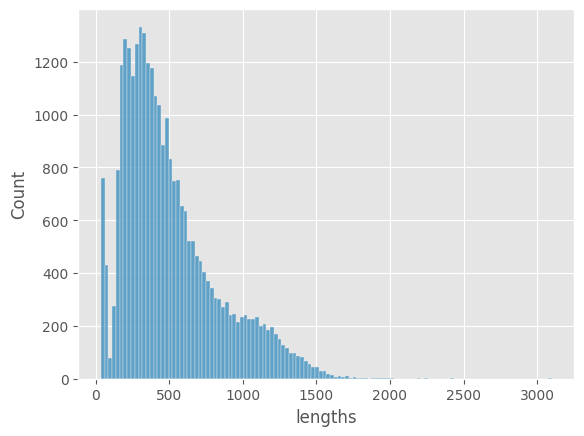

In [12]:
sns.histplot(data=df, x='lengths')
plt.show()

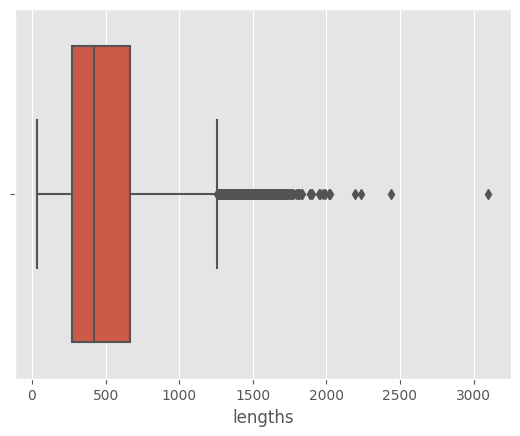

In [14]:
sns.boxplot(data=df, x='lengths')
plt.show()

In total, there are 29 284 positive sequences 

## Centering

In [15]:
file1 = open('2_no_overlap.bed', 'r')
file2 = open('3_centered_beds.bed', 'w')

In [16]:
for line in file1:
    l = line.split('\t')
    diff = int(l[2]) - int(l[1])
    b = math.floor((diff - 300) / 2)
    if diff % 2 == 0:
        print(l[0], int(l[1]) + b, int(l[2]) - b, sep='\t', file=file2)
    else:
        print(l[0], int(l[1]) + b, int(l[2]) - b - 1, sep='\t', file=file2)

## Converting to fasta

In [19]:
%%bash
bedtools getfasta -fi hg38.fa -bed 3_centered_beds.bed -fo 4_centered_fasta.fasta

## Drop unneeded elements

In [20]:
%%bash
awk '!/>/ {print}' 4_centered_fasta.fasta > 5_centered_fasta_wo.fasta

In [21]:
%%bash
awk '!/N/ {print}' 5_centered_fasta_wo.fasta > 6_centered_fasta_wo_N.fasta

## Upper letters

In [22]:
%%bash
awk '{print toupper($0)}' 6_centered_fasta_wo_N.fasta > 7_final_positive_fasta.fasta

## Generate negative samples

## 1. From genome

Take the subset from genome. Mask overlapped fragment

In [23]:
%%bash
bedtools maskfasta -fi hg38.fa -bed 1_His.ALL.50.H2APERIODZ.AllCell.bed -fo masked_hg38.fa -mc X

Drop >chr

In [24]:
%%bash
awk '!/>/ {print}' masked_hg38.fa > joint_hg38.fasta

Add the first line >hg38

In [25]:
%%bash
awk 'NR==1{$0=">hg38"RS$0}7' joint_hg38.fasta > 2_joint_hg38.fasta

Cut random pieces from hg38

In [26]:
record = SeqIO.read('2_joint_hg38.fasta', 'fasta')

In [27]:
frags = []
limit = len(record.seq)
for i in range(0, 35001): 
    start = randint(0, limit - 512)
    end = start + 512
    frag = record.seq[start:end]
    seqrecord = SeqRecord(frag, "fragment_%i" % (i + 1), "", "")
    frags.append(seqrecord)

SeqIO.write(frags, 'negseq.fasta', 'fasta-2line')

35001

To upper

In [28]:
%%bash
awk '{print toupper($0)}' negseq.fasta > negseq_1.fasta

Drop fragements with N and X and >

In [29]:
%%bash
awk '!/>/ {print}' negseq_1.fasta > negseq_2.fasta

In [30]:
%%bash
awk '!/X/ {print}' negseq_2.fasta > negseq_3.fasta

In [31]:
%%bash
awk '!/N/ {print}' negseq_3.fasta > negseq_4.fasta

Balance classes. I cut the file with negative sequences to the number of positive ones, 13123

In [32]:
%%bash
awk '{print $0} NR==28356{exit}' negseq_4.fasta > neg_seq_final_5.fasta

## Negative samples generating based on the DeePromotor method

In [33]:
def save_txt(seq_list, new_filepath):
    with open(new_filepath, "w") as f:
        f.write("\n".join(seq_list))


def read_txt(filepath):
    with open(filepath) as f:
        seq_list = f.read().splitlines()
    return seq_list

In [34]:
def get_neg_seq(pos_seq, num_part=20, keep=8):
    """
    Split the positive sequence into 20 parts, and randomly select 8 parts to keep. The remaining
    12 parts are replaced by random sequences. Adapted from https://github.com/egochao/DeePromoter
    
    :param pos_seq: the positive sequence
    :param num_part: the number of parts to split the sequence into, defaults to 20 (optional)
    :param keep: the number of parts of the sequence to keep, defaults to 8 (optional)
    :return: A string of the same length as the input sequence, but with some of the bases randomly
    replaced.
    """

    length = len(pos_seq)
    part_len = length // num_part
    if part_len * num_part < length:
        num_part += 1

    iterator = np.arange(num_part)
    keep_parts = random.sample(list(iterator), k=keep)

    outpro = list()
    for it in iterator:
        start = it * part_len
        pro_part = pos_seq[start : start + part_len]
        if it in keep_parts:
            outpro.extend(pro_part)
        else:
            pro_part = random.choices(["A", "C", "G", "T"], k=len(pro_part))
            outpro.extend(pro_part)

    return "".join(outpro)

In [35]:
def generate_neg(pos_data):
    """
    For each sequence in the positive data, generate a negative sequence by randomly shuffling the
    positive sequence
    
    :param pos_data: a list of positive sequences
    :return: A list of negative sequences.
    """
    neg_data = []
    for pos_seq in pos_data:
        neg_seq = get_neg_seq(pos_seq)
        neg_data.append(neg_seq)
    return neg_data

In [36]:
def extract_seq(ref_genome, chrx, start, end):
    return ref_genome[chrx][start:end].seq.upper()

In [37]:
# Generate negative sequences of H2AZ following DeePromoter methodology
pos_txt = "7_final_positive_fasta.fasta"
pos_data = read_txt(pos_txt)
neg_data = generate_neg(pos_data)
filepath = "neg_seq_deePromoter.fasta"
save_txt(neg_data, filepath)

## Preparing final files

In [38]:
def get_kmer_sentence(original_string, kmer=1, stride=1):
    """
    Convert to kmer format for DNABERT 
    """
    if kmer == -1:
        return original_string

    sentence = ""
    original_string = original_string.replace("\n", "")
    i = 0
    while i < len(original_string) - kmer:
        sentence += original_string[i : i + kmer] + " "
        i += stride

    return sentence[:-1].strip('"')

In [39]:
def write_file(lines, path, kmer=6, head=True, seq_index=0, label_index=1):
    """
    It takes a list of lists, where each list is a line of a file, and writes it to a file
    
    :param lines: the lines to write to the file
    :param path: the path to the file you want to write to
    :param kmer: the length of the k-mer. If kmer is 0, then the whole sequence is used
    :param head: whether to write the header or not, defaults to True (optional)
    :param seq_index: the index of the sequence in the line, defaults to 0 (optional)
    :param label_index: the index of the label in the line, defaults to 1 (optional)
    """
    with open(path, "wt") as f:
        tsv_w = csv.writer(f, delimiter="\t")
        if head:
            tsv_w.writerow(["sentence", "label"])
        for line in lines:
            if kmer == 0:
                sentence = str(line[seq_index])
            else:
                sentence = str(get_kmer_sentence("".join(line[seq_index].split()), kmer))
            if label_index is None:
                label = "0"
            else:
                label = str(line[label_index])
            tsv_w.writerow([sentence, label])

In [40]:
def Generate_prom_train_dev(neg_seq, pos_seq, valtest_percentage):

    seq = read_txt(neg_seq)
    n_neg_seq = len(seq)
    seq = seq + read_txt(pos_seq)
    seq_lbl = [0] * n_neg_seq + [1] * (len(seq) - n_neg_seq)
    seq = [list(x) for x in zip(seq, seq_lbl)]

    # shuffle all the data and split them
    random.shuffle(seq)
    num_seq_test = int(len(seq) * float(valtest_percentage))
    val_lines = seq[:num_seq_test]
    train_lines = seq[num_seq_test:] 
    
    # Save the files
    write_file(train_lines, "train.tsv")
    write_file(val_lines, "dev.tsv")
    #write_file(test_lines, "test.tsv")

Whole genome

In [41]:
neg_seq = 'neg_seq_final_5.fasta'
pos_seq = '7_final_positive_fasta.fasta'
Generate_prom_train_dev(neg_seq, pos_seq, 0.2)

DeePromoter-like 

In [42]:
neg_seq = 'neg_seq_deePromoter.fasta'
pos_seq = '7_final_positive_fasta.fasta'
Generate_prom_train_dev(neg_seq, pos_seq, 0.2)